# Chapter 23: Hybrid Approaches - Variational Classification 

We use the parameterized $qiskit4 quantum circuit over two qubits $U_{\phi(\textbf{x})}=ZZFeatureMap$ with repetition two where the parameter are defined by the data by the command $bind\_parameters$ with the two dimensional vector $\textbf{x}$.
The variational quantum circuits that represents the free parameter $\textbf{w}$ that will adapt during  training is the $qiskit$ quantum circuit  $U_{W(\textbf{w})}=TwoLocal$.
The $TwoLocal$ circuit is a parameterized circuit consisting of alternating rotation layers and entanglement layers. The rotation layers are single qubit gates applied on all qubits. The entanglement layer uses two-qubit gates to entangle the qubits according to the definition. In our example we will use the rotation gates $RX$ and $RZ$ and the  entanglement  gate  
controlled $Z$ rotation, $CZ$. with two repetitions resulting in $12$ free parameters. The twelve dimensional vector  $\textbf{w}$  defines the parameters by the  $bind\_parameters$  command. After the operations we measure the two qubits

In [1]:
from qiskit import QuantumCircuit,QuantumRegister, Aer,execute
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

x = [0.1, 0.1]
feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
feature_map = feature_map.bind_parameters(x)

weights =np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])
two_local = TwoLocal(2, ['ry', 'rz'],'cz', reps=2)
two_local = two_local.bind_parameters(weights)



qc = QuantumCircuit(2,2)
qc.compose(feature_map, inplace=True)
qc.barrier()
qc.compose(two_local, inplace=True)
qc.barrier()
qc.measure(0,0)
qc.measure(1,1)
qc.decompose().draw(fold=130)


┌───┐┌────────┐                                 ┌───┐┌────────┐                                  ░ ┌────────────────┐»
q_0: ┤ H ├┤ P(0.2) ├──■───────────────────────────■──┤ H ├┤ P(0.2) ├──■───────────────────────────■───░─┤ Ry(3.28559355) ├»
     ├───┤├────────┤┌─┴─┐┌─────────────────────┐┌─┴─┐├───┤├────────┤┌─┴─┐┌─────────────────────┐┌─┴─┐ ░ ├────────────────┤»
q_1: ┤ H ├┤ P(0.2) ├┤ X ├┤ P(18.5025717407428) ├┤ X ├┤ H ├┤ P(0.2) ├┤ X ├┤ P(18.5025717407428) ├┤ X ├─░─┤ Ry(5.48514978) ├»
     └───┘└────────┘└───┘└─────────────────────┘└───┘└───┘└────────┘└───┘└─────────────────────┘└───┘ ░ └────────────────┘»
c: 2/═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
                                                                                                                          »
«     ┌────────────────┐   ┌────────────────┐┌────────────────┐   ┌────────────────┐┌────────────────┐ ░ ┌─┐   
«q_0: ┤ Rz(5.13099949) ├─■─┤ Ry(4.08885928) ├┤ Rz(4.92364593) ├─■─┤ Ry(3.66837805) ├┤ Rz(3.60713748) ├─░─┤M├───
«     ├────────────────┤ │ ├────────────────┤├────────────────┤ │ ├────────────────┤└┬─────────────┬─┘ ░ └╥┘┌─┐
«q_1: ┤ Rz(0.88372228) ├─■─┤ Ry(2.45568528) ├┤ Rz(5.59032015) ├─■─┤ Ry(4.84632313) ├─┤ Rz(2.43546) ├───░──╫─┤M├
«     └────────────────┘   └────────────────┘└────────────────┘   └────────────────┘ └─────────────┘   ░  ║ └╥┘
«c: 2/════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩═
«                                                                                                         0  1


Total count are: {'01': 5512, '00': 760, '11': 1891, '10': 1837}


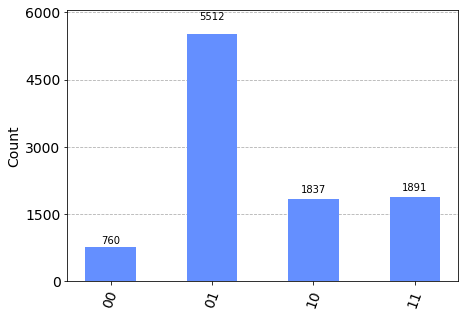

In [2]:
simulator = Aer.get_backend('qasm_simulator')
result=execute(qc,simulator,shots=10000).result()
counts = result.get_counts()
print("\nTotal count are:",counts)

plot_histogram(counts)

We perform 1$0000$ shots.
 The string $01$ appears (approximately) $5483$ times and the string $10$ appears  (approximately)  $1892$. 
 We define the binary output from the binary string by a parity function,  $p(1)=o_k=(5483+1892)/1000=0.7375$.

## $Qiskit$ Variational Quantum Classifier

In this simple $qiskit$  example we create $10$ two dimensional training data points and $5$ testing data points  for two classes each.
 We use  the same classification circuit as before.
We one hot encode our labels, as required by the algorithm using cross entropy.
Then, we set up our classical optimizer and the VQC algorithm  using the callback function.
We plot the cost function with respect to optimization step,

In [3]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=10,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)

In [4]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)
AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)

In [5]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(TRAIN_LABELS.reshape(-1, 1)
                                       ).toarray()
test_labels_oh = encoder.fit_transform(TEST_LABELS.reshape(-1, 1)
                                      ).toarray()

In [6]:
from qiskit.algorithms.optimizers import SPSA

class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
                          0.96566328, 0.38243769, 0.90403094,
                          0.82271449, 0.26810137, 0.61076489,
                          0.82301609, 0.11789148, 0.29667125])

from qiskit_machine_learning.algorithms.classifiers import VQC
log = OptimizerLog()
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=initial_point)

vqc.fit(TRAIN_DATA, train_labels_oh)

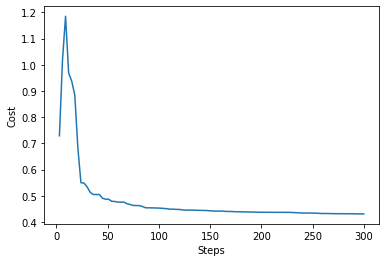

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

We plot the cost function with respect to optimization step, we can see it starts to converge to a minimum

Finally we test our trained VQC classifier by score.

In [8]:
# score == accuracy
vqc.score(TEST_DATA, test_labels_oh)

0.9